In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import os

from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


print('Current cuda device is', device)

Current cuda device is cpu


In [3]:
# 데이터셋 경로와 파일 리스트 가져오기
data_dir = './training_dataset/tr/'
file_list = os.listdir(data_dir)  # 이미지 파일 리스트를 가져옵니다.

# 데이터 전처리 및 DataLoader 설정
transform = transforms.Compose([
    transforms.Resize((200, 200)),  # 이미지 크기 조정 
    transforms.ToTensor(),           # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 이미지 정규화 (평균 0.5, 표준 편차 0.5)
])

class CustomDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(data_dir, self.file_list[idx])
        image = Image.open(img_path)
        age = int(self.file_list[idx].split("_")[0])  # 파일명에서 나이 정보 추출

        if self.transform:
            image = self.transform(image)

        return image, age

# 데이터 분할
train_files, val_files = train_test_split(file_list, test_size=0.2, random_state=42)

# DataLoader 설정
train_dataset = CustomDataset(train_files, transform=transform)
val_dataset = CustomDataset(val_files, transform=transform)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [4]:
import torch.nn as nn

class AgePredictionModel(nn.Module):
    def __init__(self):
        super(AgePredictionModel, self).__init__()
        self.fc = nn.Linear(200 * 200 * 3, 1)  # 입력 이미지 크기에 맞는 Fully Connected 레이어

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten 작업
        x = self.fc(x)
        return x

model = AgePredictionModel()


In [5]:
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [6]:
# Hyperparameter 설정
num_epochs = 10

# Learning Curve를 그리기 위한 리스트 초기화
train_losses = []
val_losses = []

In [7]:

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.view(-1), labels.float())   # view 메소드 수정 
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 훈련 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}")
    # 훈련 손실 기록
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    # 검증 데이터셋에 대한 손실 계산
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs.view(-1), labels.float())   # view 메소드 수정 
            val_loss += loss.item()
     # 검증 손실 기록
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    # 에폭별로 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss/len(val_loader)}")


Epoch 1/10, Training Loss: 472.02381106645635
Epoch 1/10, Validation Loss: 9.392946560250774
Epoch 2/10, Training Loss: 413.5661978697165
Epoch 2/10, Validation Loss: 8.324881239465652
Epoch 3/10, Training Loss: 375.11070916591547
Epoch 3/10, Validation Loss: 6.757483123690325
Epoch 4/10, Training Loss: 347.6694265121069
Epoch 4/10, Validation Loss: 8.409272536691255
Epoch 5/10, Training Loss: 315.2514678955078
Epoch 5/10, Validation Loss: 8.560035232105438
Epoch 6/10, Training Loss: 288.84679459791914
Epoch 6/10, Validation Loss: 10.775866475516386
Epoch 7/10, Training Loss: 304.944490638146
Epoch 7/10, Validation Loss: 6.327817466446679
Epoch 8/10, Training Loss: 294.70789912297175
Epoch 8/10, Validation Loss: 6.588670710730881
Epoch 9/10, Training Loss: 298.4826719626402
Epoch 9/10, Validation Loss: 6.592547656992285
Epoch 10/10, Training Loss: 293.97401518210387
Epoch 10/10, Validation Loss: 7.637837293593896


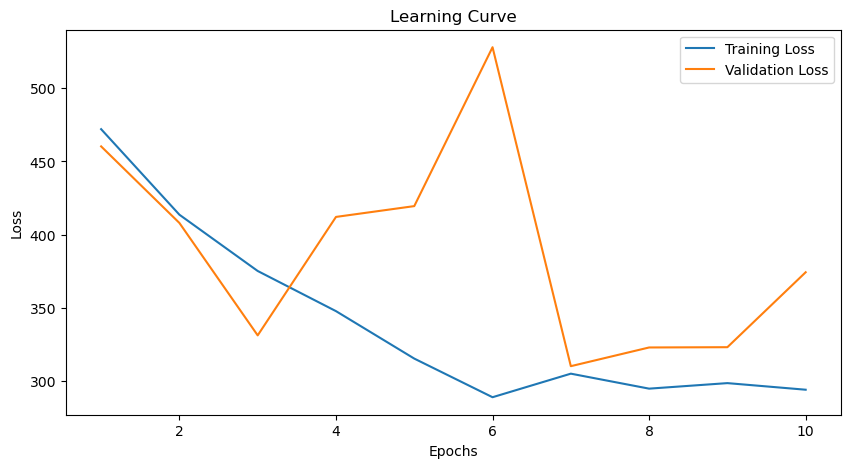

In [8]:
# Learning Curve 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()

In [9]:
print(train_losses)
print(val_losses) 

[472.02381106645635, 413.5661978697165, 375.11070916591547, 347.6694265121069, 315.2514678955078, 288.84679459791914, 304.944490638146, 294.70789912297175, 298.4826719626402, 293.97401518210387]
[460.25438145228793, 407.919180733817, 331.1166730608259, 412.0543542978715, 419.44172637316643, 528.0174573003029, 310.0630558558873, 322.84486482581315, 323.034835192622, 374.2540273861009]


In [10]:
from torchsummary import summary



summary(model, input_size=(3,200,200), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]         120,001
Total params: 120,001
Trainable params: 120,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 0.00
Params size (MB): 0.46
Estimated Total Size (MB): 0.92
----------------------------------------------------------------
